# The "Titanic - Machine Learning from Disaster" project

Source: https://www.kaggle.com/competitions/titanic/data

In this notebook, we'll build a machine learning model to classify which Titanic passengers survived the disaster

Tools we're going to use:
* Numpy
* Pandas
* Matplotlib
* Scikit Learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the available data

In [3]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data preprocessing

Check if the data has missing values

In [6]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Check if all features are numerical

In [8]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Create a pipeline that will preprocess the data

Let's turn all non-numeric features into numbers and take care of missing values

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [10]:
categorical_features = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]
# ACTUALLY WAIT WITH IT TILL THE END

### Explore the data

In [11]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


C:\Users\szymo\AppData\Local\Temp\ipykernel_4276\3809384158.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age = train_df.groupby("AgeGroup")["Survived"].mean()


<Axes: xlabel='Pclass'>

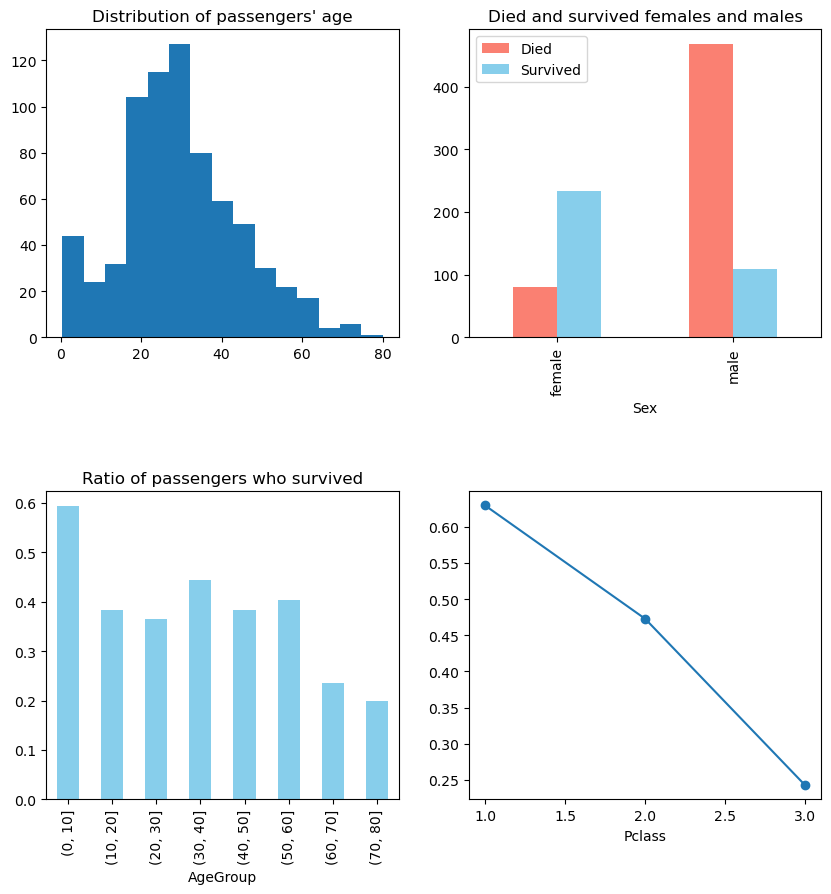

In [12]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
# fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

ax0.set_title("Distribution of passengers' age")
ax0.hist(train_df["Age"], bins=15);

# survived_df = train_df[train_df["Survived"] == 1]
# survived_counts = survived_df["Sex"].value_counts().sort_index()
# survived_counts.index = ["survived females", "survived males"]
# died_df = train_df[train_df["Survived"] == 0]
# died_counts = died_df["Sex"].value_counts().sort_index()
# died_counts.index = ["died females", "died males"]
# counts = pd.concat([survived_counts, died_counts])
# ax1.bar(counts.index, counts.values)
# ax1.set_xticks(range(len(counts)))
# ax1.set_xticklabels(counts.index, rotation=90);
counts = pd.crosstab(train_df["Sex"], train_df["Survived"])
counts.columns = ["Died", "Survived"]
counts.plot(kind="bar", ax=ax1, color=["salmon", "skyblue"])
ax1.set_title("Died and survived females and males")

train_df["AgeGroup"] = pd.cut(train_df["Age"], bins=range(0,90,10))
survival_by_age = train_df.groupby("AgeGroup")["Survived"].mean()
survival_by_age.plot(kind="bar", ax=ax2, color="skyblue")
# ax2.bar(survival_by_age.index.astype(str), survival_by_age.values, color="skyblue")
train_df = train_df.drop(labels="AgeGroup", axis=1)
ax2.set_title("Ratio of passengers who survived")

survival_by_class = train_df.groupby("Pclass")["Survived"].mean()
survival_by_class.plot(marker="o")


## Prepare dataset

In [2]:
import re

def adjust_features(data, test=False):
    data = data.copy()
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    def extract_title(x):
        match = re.search(r"(Mr|Mrs|Miss|Master|Dr|Rev|Col|Major|Mlle|Mme|Ms|Countess|Lady|Sir|Jonkheer|Don|Dona|Capt)", x)
        return match.group(1) if match else "Other"

    def ticket_number(x):
        return x.split(" ")[-1]

    # def ticket_item(x):
    #     items = x.split(" ")
    #     if len(items) == 1:
    #         return "NONE"
    #     return "_".join(items[:-1])

    data["Name"] = data["Name"].apply(normalize_name)
    data["Title"] = data["Name"].apply(extract_title)
    # data["TicketNumber"] = data["Ticket"].apply(ticket_number)
    data["TicketNumber"] = pd.to_numeric(data["Ticket"].apply(ticket_number), errors='coerce').astype("Int64") # ensure it
    # data["TicketItem"] = data["Ticket"].apply(ticket_item)

    return data

In [ ]:
ready_train_df = adjust_features(train_df)
ready_train_df.head()

## Prepare X and y

In [14]:
def yield_X_y(data, test=False):
    data = data.dropna(subset=["Survived"])
    
    input_features = list(data.columns)
    input_features.remove("Name")
    input_features.remove("Ticket")
    input_features.remove("PassengerId")
    input_features.remove("Survived")
    return data[input_features], data["Survived"]

In [15]:
X, y = yield_X_y(ready_train_df)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,TicketNumber
0,3,male,22.0,1,0,7.2500,NaN,S,Mr,21171
1,1,female,38.0,1,0,71.2833,C85,C,Mr,17599
2,3,female,26.0,0,0,7.9250,NaN,S,Miss,3101282
3,1,female,35.0,1,0,53.1000,C123,S,Mr,113803
4,3,male,35.0,0,0,8.0500,NaN,S,Mr,373450


## Fill in missing values

In [16]:
from pandas.api.types import is_numeric_dtype

def fill_missing_values(data, future=False, training_data=None):
    for column in data.columns:
        if is_numeric_dtype(data[column]):
            data[column] = data[column].fillna(int(data[column].median()) if not future else int(training_data[column].median()))
        else:
            data[column] = data[column].fillna("missing")
    return data

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 10), (179, 10), (712,), (179,))

In [18]:
X_train = fill_missing_values(X_train)
X_val = fill_missing_values(X_val, future=True, training_data=X_train)

## Turn categorical features into numbers

In [19]:
def fit_categorical_features(training_data):
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    categorical_features = [column for column in training_data.columns if not is_numeric_dtype(training_data[column])]
    
    # encoded_array = encoder.fit_transform(data[categorical_features])
    # encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features), index=data.index)
    encoder.fit(training_data[categorical_features])
    
    return encoder, categorical_features
    # data = data.drop(labels=categorical_features, axis=1)
    # data = pd.concat([data, encoded_df], axis=1)
    # return data

def encode_categorical_features(data, encoder, categorical_features):
    encoded_array = encoder.transform(data[categorical_features])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features), index=data.index)

    data = data.drop(labels=categorical_features, axis=1)
    data = pd.concat([data, encoded_df], axis=1)
    return data

In [20]:
encoder, categorical_features = fit_categorical_features(X_train)
X_train = encode_categorical_features(X_train, encoder, categorical_features)
X_val = encode_categorical_features(X_val, encoder, categorical_features)

In [21]:
X_train.dtypes

Pclass         int64
Age          float64
SibSp          int64
Parch          int64
Fare         float64
              ...   
Title_Mme    float64
Title_Mr     float64
Title_Ms     float64
Title_Rev    float64
Title_Sir    float64
Length: 148, dtype: object

In [22]:
ready_train_df[ready_train_df["TicketNumber"].isna()] # just to check the original data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketNumber
179,180,0,3,Leonard Mr Lionel,male,36.0,0,0,LINE,0.0,NaN,S,Mr,<NA>
271,272,1,3,Tornquist Mr William Henry,male,25.0,0,0,LINE,0.0,NaN,S,Mr,<NA>
302,303,0,3,Johnson Mr William Cahoone Jr,male,19.0,0,0,LINE,0.0,NaN,S,Mr,<NA>
597,598,0,3,Johnson Mr Alfred,male,49.0,0,0,LINE,0.0,NaN,S,Mr,<NA>


## Now once our data is ready to use, let's decide which model works best

In [23]:
len(X_train)

712

In [6]:
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
models = {"LinearSVC": LinearSVC(), "SVC": SVC(), "KNeighborsClassifier": KNeighborsClassifier(), "RandomForestClassifier": RandomForestClassifier(), "LogisticRegression": LogisticRegression()}

In [8]:
for key, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    print(f"{key} scored {score*100:.2f}% accuracy")

NameError: name 'X_train' is not defined

We can clearly see that RandomForestClassifier performed far better than any other model, let's continue with it

## Let's create the RandomForestClassifier model with the help of Pipelines

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.model_selection import cross_val_score

In [4]:
data = pd.read_csv("./data/train.csv")
data = adjust_features(data)
# y.isna().sum() # no empty labels
y_train = data["Survived"]
X_train = data.drop(labels=["Name", "Ticket", "PassengerId", "Survived"], axis=1)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,TicketNumber
0,3,male,22.0,1,0,7.2500,NaN,S,Mr,21171
1,1,female,38.0,1,0,71.2833,C85,C,Mr,17599
2,3,female,26.0,0,0,7.9250,NaN,S,Miss,3101282
3,1,female,35.0,1,0,53.1000,C123,S,Mr,113803
4,3,male,35.0,0,0,8.0500,NaN,S,Mr,373450


In [5]:
X_train.isna().sum()

Pclass            0
Sex               0
Age             177
SibSp             0
Parch             0
Fare              0
Cabin           687
Embarked          2
Title             0
TicketNumber      4
dtype: int64

In [6]:
from pandas.api.types import is_numeric_dtype

num_features = [feature for feature in X_train.columns if is_numeric_dtype(X_train[feature])]
cat_features = [feature for feature in X_train.columns if not is_numeric_dtype(X_train[feature])]

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

In [33]:
%%time

params = {
    "preprocessor__num__strategy": ["median", "mean"],
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
}

gs_rf = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
CPU times: total: 5.53 s
Wall time: 44.8 s


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__max_depth': [None, 5, ...], 'clf__min_samples_leaf': [1, 2, ...], 'clf__min_samples_split': [2, 5, ...], 'clf__n_estimators': [50, 100, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [34]:
gs_rf.best_params_

{'clf__max_depth': 10,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 5,
 'clf__n_estimators': 200,
 'preprocessor__num__strategy': 'median'}

In [35]:
gs_rf.best_score_

np.float64(0.8384031134266523)

In [36]:
y_train.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [37]:
def get_feature_names(preprocessor):
    feature_names = []
    # Iterate over transformers
    for name, transformer, columns in preprocessor.transformers_:
        # if name == 'remainder' and transformer == 'passthrough':
        #     feature_names.extend(columns)
        #     print("runs")
        # else:
        # If transformer has get_feature_names_out (like OneHotEncoder)
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns
        feature_names.extend(names)
    return feature_names

In [38]:
feature_importances = gs_rf.best_estimator_['clf'].feature_importances_
feature_names = get_feature_names(gs_rf.best_estimator_["preprocessor"])

In [39]:
len(feature_importances), len(feature_names)

(176, 176)

In [40]:
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
})
feat_imp_df

,feature,importance
0,Pclass,0.074153
1,Age,0.071516
2,SibSp,0.040704
3,Parch,0.026930
4,Fare,0.102770
...,...,...
171,Title_Mme,0.000182
172,Title_Mr,0.043670
173,Title_Ms,0.000377
174,Title_Rev,0.002039


In [41]:
for name, transformer, columns in gs_rf.best_estimator_["preprocessor"].transformers_:
    print(name, transformer, columns)

num SimpleImputer(strategy='median') ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TicketNumber']
cat OneHotEncoder(handle_unknown='ignore') ['Sex', 'Cabin', 'Embarked', 'Title']


### Ten most important features when it comes to predicting survival chances

In [42]:
top_features = feat_imp_df.sort_values(by="importance", ascending=False).head(10)
top_features

,feature,importance
6,Sex_female,0.173922
7,Sex_male,0.156537
4,Fare,0.102770
5,TicketNumber,0.088488
0,Pclass,0.074153
1,Age,0.071516
169,Title_Miss,0.050519
172,Title_Mr,0.043670
155,Cabin_nan,0.041013
2,SibSp,0.040704


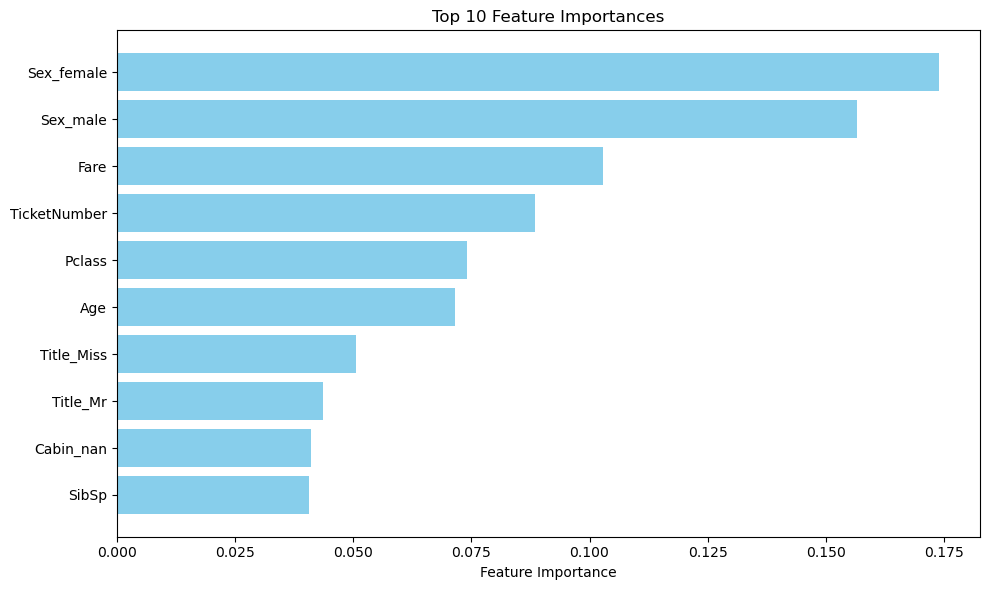

In [43]:
plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

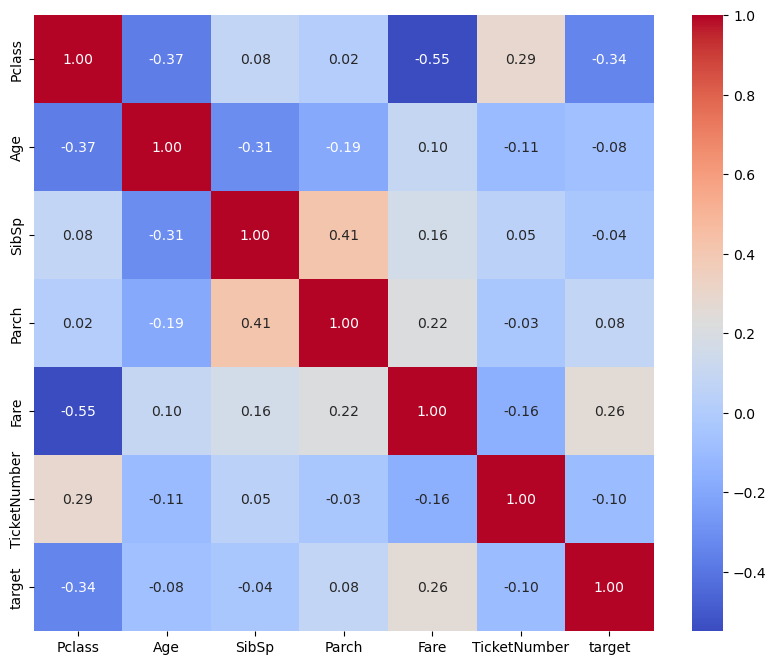

In [44]:
import seaborn as sns

df = X_train.select_dtypes(include=np.number).copy()
df["target"] = y_train

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [45]:
y_preds = gs_rf.predict(X_train)

In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_preds)
accuracy

0.8967452300785634

In [59]:
X_test = pd.read_csv("./data/test.csv")
X_test = adjust_features(X_test)
passenger_ids
X_test = X_test.drop(labels=["Name", "Ticket", "PassengerId"], axis=1)
y_test = gs_rf.predict(X_test)

In [61]:
submission_df = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test
})
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
